In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import yellowbrick
from sklearn.linear_model import LinearRegression

ModuleNotFoundError: No module named 'yellowbrick'

**Conjunto de dados**

Variáveis gorjeta (tips), conta total paga pelos clientes (total_bill), dias (day) e horários (time), sexo (sex), se são fumantes ou não (smokers) e o tamanho da mesa (size)

In [ ]:
dados = pd.read_csv("https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv")

In [ ]:
dados.shape

(244, 7)

In [ ]:
dados.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


### Verificações

Possui valores faltantes?

In [ ]:
dados.isna().sum()

total_bill    0
tip           0
sex           0
smoker        0
day           0
time          0
size          0
dtype: int64

Possui duplicatas?

In [ ]:
dados.drop_duplicates().shape[0] == dados.shape[0]

False

Tipo dos dados

In [ ]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244 entries, 0 to 243
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total_bill  244 non-null    float64
 1   tip         244 non-null    float64
 2   sex         244 non-null    object 
 3   smoker      244 non-null    object 
 4   day         244 non-null    object 
 5   time        244 non-null    object 
 6   size        244 non-null    int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 13.5+ KB


In [ ]:
colunas_objeto = dados.select_dtypes('object').columns.to_list() 
colunas_numerico = dados.select_dtypes(['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns.to_list()

## **Definição do problema**

Predizer a gorjeta paga pelo cliente com base nas outras características (total pago, sexo...)

## **Análises preliminares**

Descritiva

In [ ]:
dados.describe()

,total_bill,tip,size
count,244.000000,244.000000,244.000000
mean,19.785943,2.998279,2.569672
std,8.902412,1.383638,0.951100
min,3.070000,1.000000,1.000000
25%,13.347500,2.000000,2.000000
50%,17.795000,2.900000,2.000000
75%,24.127500,3.562500,3.000000
max,50.810000,10.000000,6.000000


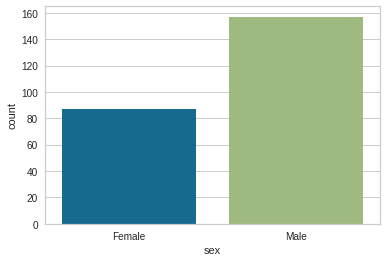

In [ ]:
sns.countplot(x="sex", data=dados)

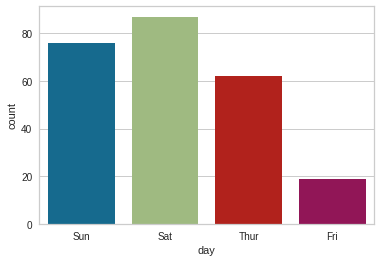

In [ ]:
sns.countplot(x="day", data=dados)

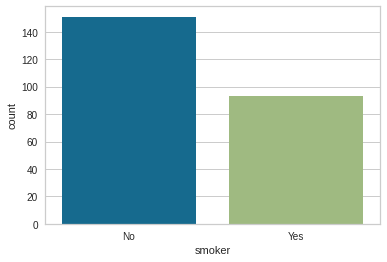

In [ ]:
sns.countplot(x="smoker", data=dados)

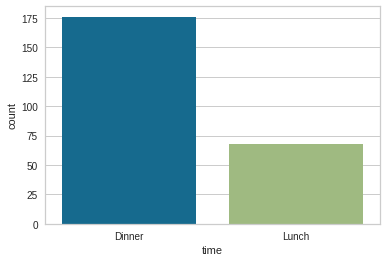

In [ ]:
sns.countplot(x="time", data=dados)

Relações entre as variáveis

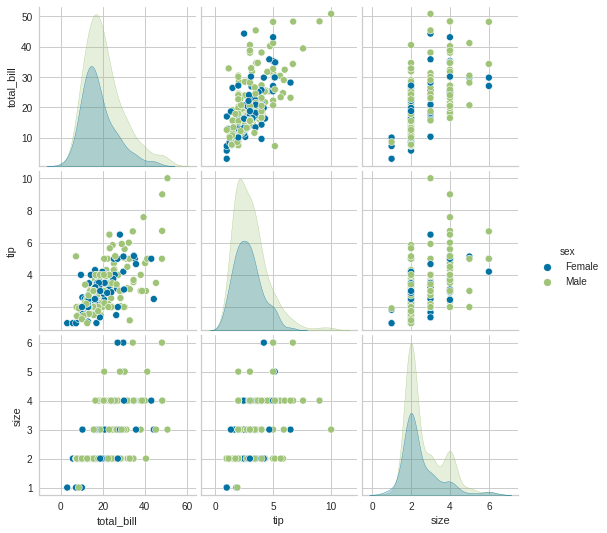

In [ ]:
sns.pairplot(dados, hue = "sex")

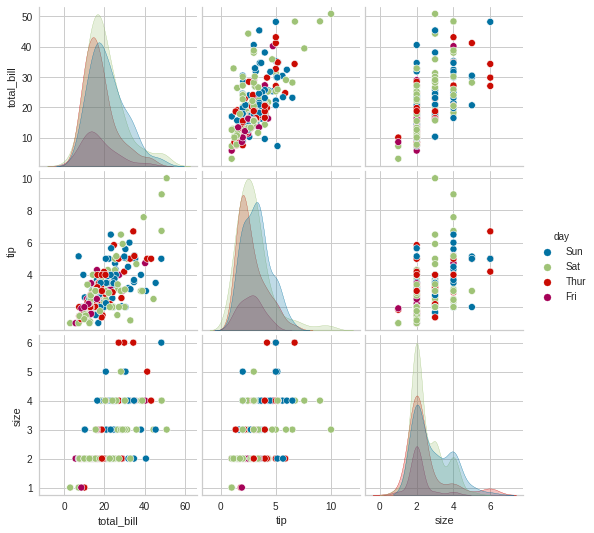

In [ ]:
sns.pairplot(dados, hue = "day")

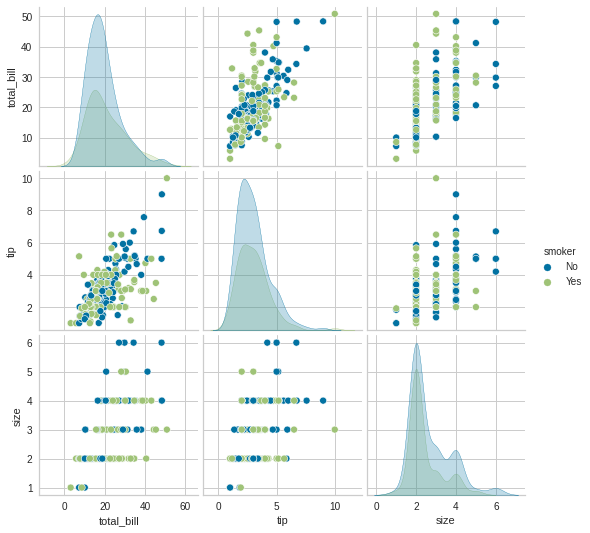

In [ ]:
sns.pairplot(dados, hue = "smoker")

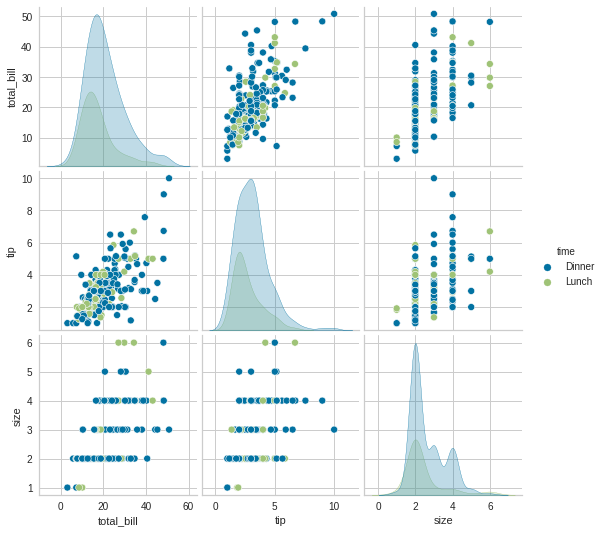

In [ ]:
sns.pairplot(dados, hue = "time")

## Modelagem

Codificação de variáveis categóricas

In [ ]:
x = pd.get_dummies(dados.drop('tip', axis = 1), columns=colunas_objeto, drop_first = True)
y = dados[['tip']]

In [ ]:
x.head(3)

,total_bill,size,sex_Male,smoker_Yes,day_Sat,day_Sun,day_Thur,time_Lunch
0,16.99,2,0,0,0,1,0,0
1,10.34,3,1,0,0,1,0,0
2,21.01,3,1,0,0,1,0,0


Treino e teste

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y)

#### Regressão linear

In [ ]:
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [ ]:
coefficients = pd.concat([pd.DataFrame(x_train.columns),pd.DataFrame(np.transpose(model.coef_))], axis = 1)
coefficients.columns = ["x", "coefficient"]
coefficients

,x,coefficient
0,total_bill,0.091208
1,size,0.217625
2,sex_Male,-0.014599
3,smoker_Yes,-0.052176
4,day_Sat,-0.372335
5,day_Sun,-0.159261
6,day_Thur,-0.137849
7,time_Lunch,-0.171635


Predição do conjunto de teste

In [ ]:
y_test_predict = model.predict(x_test)

In [ ]:
residual = (y_test - y_test_predict)

Métricas

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print("MAE", mean_absolute_error(y_test, y_test_predict))
print("MSE", mean_squared_error(y_test, y_test_predict))
print("RMSE", np.sqrt(mean_squared_error(y_test, y_test_predict)))
print("R2", r2_score(y_test, y_test_predict))

MAE 0.6408208654420048
MSE 0.7452351448180535
RMSE 0.8632700300705762
R2 0.5786143099805117


### Análise de resíduos

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


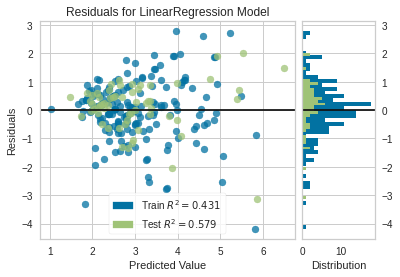

In [ ]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(model)
visualizer.fit(x_train, y_train.values)  
visualizer.score(x_test, y_test.values)  
visualizer.show()   

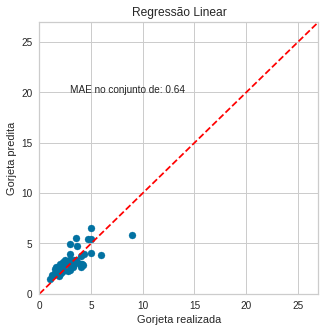

In [ ]:
mae = mean_absolute_error(y_test, y_test_predict)
string_score = f"\nMAE no conjunto de: {mae:.2f}"
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_test_predict)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(3, 20, string_score)
plt.title("Regressão Linear")
plt.ylabel("Gorjeta predita")
plt.xlabel("Gorjeta realizada")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

## Comparação de modelos

### Transformação Box-Cox

In [ ]:
from sklearn.preprocessing import PowerTransformer
boxcox = PowerTransformer(method = 'box-cox')
y_train_bc = boxcox.fit_transform(y_train)
y_test_bc = boxcox.transform(y_test)

In [ ]:
model_boxcox = LinearRegression()
model_boxcox.fit(x_train, y_train_bc)

LinearRegression()

In [ ]:
y_test_bc_predict = model_boxcox.predict(x_test)

In [ ]:
residual_bc = (y_test_bc - y_test_bc_predict)

In [ ]:
print("MAE", mean_absolute_error(y_test_bc, y_test_bc_predict))
print("MSE", mean_squared_error(y_test_bc, y_test_bc_predict))
print("RMSE", np.sqrt(mean_squared_error(y_test_bc, y_test_bc_predict)))
print("R2", r2_score(y_test_bc, y_test_bc_predict))

MAE 0.49520497314274353
MSE 0.3720233255594802
RMSE 0.6099371488600118
R2 0.5734647196559417


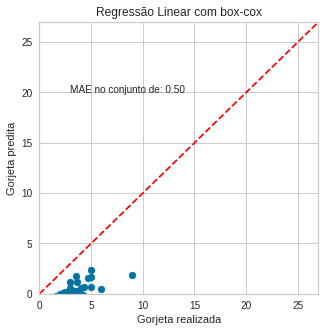

In [ ]:
mae = mean_absolute_error(y_test_bc, y_test_bc_predict)
string_score = f"\nMAE no conjunto de: {mae:.2f}"
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_test_bc_predict)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(3, 20, string_score)
plt.title("Regressão Linear com box-cox")
plt.ylabel("Gorjeta predita")
plt.xlabel("Gorjeta realizada")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

### Árvore de decisão

In [ ]:
from sklearn.tree import DecisionTreeRegressor
model_dt = DecisionTreeRegressor()
model_dt.fit(x_train, y_train)

DecisionTreeRegressor()

In [ ]:
y_test_dt_predict = model_dt.predict(x_test)

In [ ]:
print("MAE", mean_absolute_error(y_test, y_test_dt_predict))
print("MSE", mean_squared_error(y_test, y_test_dt_predict))
print("RMSE", np.sqrt(mean_squared_error(y_test, y_test_dt_predict)))
print("R2", r2_score(y_test, y_test_dt_predict))

MAE 0.7095081967213115
MSE 1.033750819672131
RMSE 1.0167353734734181
R2 0.41547603399447197


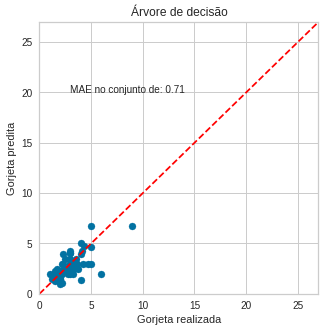

In [ ]:
mae = mean_absolute_error(y_test, y_test_dt_predict)
string_score = f"\nMAE no conjunto de: {mae:.2f}"
fig, ax = plt.subplots(figsize=(5, 5))
plt.scatter(y_test, y_test_dt_predict)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
plt.text(3, 20, string_score)
plt.title("Árvore de decisão")
plt.ylabel("Gorjeta predita")
plt.xlabel("Gorjeta realizada")
plt.xlim([0, 27])
_ = plt.ylim([0, 27])

## Resumo

In [ ]:
MAE = [mean_absolute_error(y_test, y_test_predict), 
       mean_absolute_error(y_test_bc, y_test_bc_predict),
       mean_absolute_error(y_test, y_test_dt_predict)]

MSE = [mean_squared_error(y_test, y_test_predict),
       mean_squared_error(y_test_bc, y_test_bc_predict),
       mean_squared_error(y_test, y_test_dt_predict)]

R2 = [r2_score(y_test, y_test_predict),
      r2_score(y_test_bc, y_test_bc_predict),
      r2_score(y_test, y_test_dt_predict)]

RMSE = np.sqrt(MSE)

In [ ]:
tabela_metricas = pd.DataFrame(list(zip(MAE, MSE, RMSE, R2)),
               columns =['MAE', 'MSE', 'RMSE', 'R2'], index = ['Regressão linear', 'Regressão linear com box-cox', 'Árvore de decisão'])
tabela_metricas

,MAE,MSE,RMSE,R2
Regressão linear,0.640821,0.745235,0.863270,0.578614
Regressão linear com box-cox,0.495205,0.372023,0.609937,0.573465
Árvore de decisão,0.709508,1.033751,1.016735,0.415476
